In [1]:
Alpha_Name = "Original_Input_Moving_10_Shift_5"
start_date = "2020-01-01"
end_date = "2020-06-01"

In [5]:
import time
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
model_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/" + "%s_%s" %(start_date,end_date) + "/"
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)
data_path = "/home/ShareFolder/feature_platform/ti0/wuwenjun/#Data_lib/"

In [6]:
from AlphaNet.Data import DataLoader
trainloader = DataLoader()
trainloader.load_data_from_file(alpha_name = Alpha_Name,end_date = start_date,data_path=data_path)

100%|██████████| 1219/1219 [01:40<00:00, 12.16it/s]


0            1            2  \
timestamp           ticker                                          
2015-02-16 09:30:00 000001  1047.509016   924.464829   926.891342   
                    000002  5734.296871  4441.200376  4471.782349   
                    000004     1.642506     1.901233     0.990144   
                    000005     0.000000     0.000000     0.000000   
                    000006    72.269658    56.316516    54.038229   
...                                 ...          ...          ...   
2019-12-31 09:30:00 688168     8.466044     9.039311     8.003211   
                    688188    10.373478    12.624011     9.980378   
                    688321     6.645560     3.518322     3.704553   
                    688333     8.330189     7.817017     7.413417   
                    688388     0.480808     0.625063     0.386331   

                                      3             4          5          6  \
timestamp           ticker                                                    
2015-02-16 09:30:00 000001   957.587687  1.370681e+07 -19.882971  13.934422   
                    000002  4870.817595  6.234416e+07 -45.842258  64.459181   
                    000004     1.578639 -1.669329e+03  -2.609840  -0.199015   
                    000005     0.000000  0.000000e+00   0.000000   0.000000   
                    000006    62.654442  1.920453e+06  -4.720388  14.343406   
...                                 ...           ...        ...        ...   
2019-12-31 09:30:00 688168     8.572603  1.447176e+02  -2.365073   0.124715   
                    688188    10.646007 -4.433030e+03  -3.270370  -1.935004   
                    688321     5.245107  2.771588e+04  -2.202818   6.830212   
                    688333     7.856886  6.054595e+03  -3.423879   3.371258   
                    688388     0.510829 -1.993854e+03  -0.688565  -0.377332   

                                    7            8            9  ...  \
timestamp           ticker                                       ...   
2015-02-16 09:30:00 000001  27.628015   887.325873   995.996587  ...   
                    000002  77.675326  5319.398731  6091.649138  ...   
                    000004  -0.269409     1.274784     1.700233  ...   
                    000005   0.000000     0.000000     0.000000  ...   
                    000006  23.635329    70.261231    67.609691  ...   
...                               ...          ...          ...  ...   
2019-12-31 09:30:00 688168   0.124715     9.009933    10.005129  ...   
                    688188  -1.935004    11.475873    16.679551  ...   
                    688321   6.830212     5.048278     5.640524  ...   
                    688333   3.371258     7.287800     6.993156  ...   
                    688388  -0.377332     0.820721     0.916929  ...   

                                    531          532          533  \
timestamp           ticker                                          
2015-02-16 09:30:00 000001   978.643091   992.024364   965.825273   
                    000002  1542.343273  1573.236000  1507.843455   
                    000004    70.438364    71.750727    69.915818   
                    000005    38.000000    38.000000    38.000000   
                    000006   200.070182   202.711818   197.666727   
...                                 ...          ...          ...   
2019-12-31 09:30:00 688168   102.764000   105.264545   100.554909   
                    688188   153.863818   157.963091   151.208364   
                    688321    55.512909    56.669636    54.513091   
                    688333    55.839455    56.972727    54.799091   
                    688388    51.523455    54.036727    50.757273   

                                    534          535           536       537  \
timestamp           ticker                                                     
2015-02-16 09:30:00 000001   977.906545   980.427946  8.618504e+05  0.284385   
                    000002  1542.1650

In [7]:
train_loader = trainloader.to_torch_DataLoader(sequence = 5,shuffle=True)
trainloader.shape

torch.Size([3671787, 5, 108])

In [10]:
LR = 0.001
epoch_num = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()
model = AlphaNet_LSTM_V1(108, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 64, num_layers=5, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.001


 10%|█         | 1/10 [01:07<10:05, 67.23s/it]

Epoch:  1  loss:  0.7124789460180275


 20%|██        | 2/10 [02:27<09:59, 74.98s/it]

Epoch:  2  loss:  0.6995522106845238


 30%|███       | 3/10 [04:22<10:52, 93.23s/it]

Epoch:  3  loss:  0.690537625550602


 40%|████      | 4/10 [05:51<09:09, 91.63s/it]

Epoch:  4  loss:  0.6813973113479442


 50%|█████     | 5/10 [07:34<07:58, 95.63s/it]

Epoch:  5  loss:  0.6716152832703207


 60%|██████    | 6/10 [09:36<06:58, 104.74s/it]

Epoch:  6  loss:  0.6620788183833729


 70%|███████   | 7/10 [11:04<04:57, 99.16s/it] 

Epoch:  7  loss:  0.6533240493831085


 80%|████████  | 8/10 [12:11<02:57, 88.85s/it]

Epoch:  8  loss:  0.6434322313903551


 90%|█████████ | 9/10 [13:35<01:27, 87.28s/it]

Epoch:  9  loss:  0.6347965086607017


100%|██████████| 10/10 [14:42<00:00, 88.30s/it]

Epoch:  10  loss:  0.6261873428424437


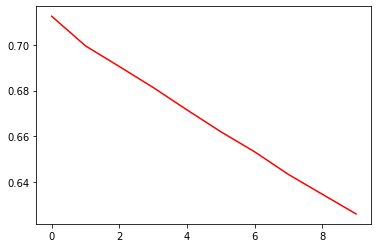

In [11]:
model = model_loader.fit_transform(train_loader,optimizer,loss_function,epoch_num,save_path = model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.001


 10%|█         | 1/10 [01:19<11:57, 79.70s/it]

Epoch:  1  loss:  0.5240814787646847


 20%|██        | 2/10 [02:18<09:01, 67.69s/it]

Epoch:  2  loss:  0.5213933169333977


 30%|███       | 3/10 [03:17<07:23, 63.38s/it]

Epoch:  3  loss:  0.5186178164314958


 40%|████      | 4/10 [04:16<06:11, 61.87s/it]

Epoch:  4  loss:  0.5164003182903542


 50%|█████     | 5/10 [05:42<05:52, 70.44s/it]

Epoch:  5  loss:  0.5148824119072877


 60%|██████    | 6/10 [08:16<06:35, 98.79s/it]

Epoch:  6  loss:  0.5116208388020681


 70%|███████   | 7/10 [10:05<05:06, 102.28s/it]

Epoch:  7  loss:  0.5099015346235607


 80%|████████  | 8/10 [12:10<03:38, 109.48s/it]

Epoch:  8  loss:  0.5077647012148286


 90%|█████████ | 9/10 [13:48<01:45, 105.94s/it]

Epoch:  9  loss:  0.505535340962605


100%|██████████| 10/10 [15:52<00:00, 95.29s/it] 

Epoch:  10  loss:  0.5037570888620456


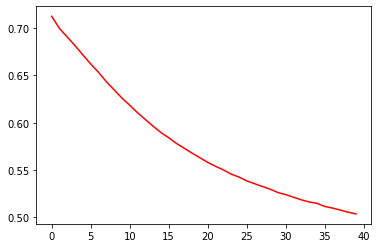

In [15]:
optimizer = optim.Adam(model.parameters(), lr=LR)
model = model_loader.transform(optimizer = optimizer, epoch_num = 10, method="best")

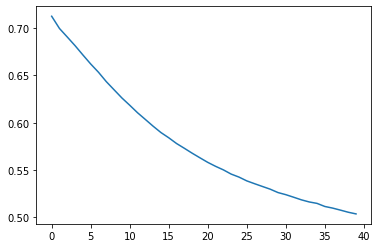

In [16]:
plt.plot(model_loader.loss_list)

In [19]:
testloader = DataLoader()
testloader.load_data_from_file(alpha_name = Alpha_Name,start_date = start_date,end_date = end_date,data_path=data_path)
test_loader = testloader.to_torch_DataLoader(sequence = 5,shuffle=False)
pred = model_loader.pred(test_loader)

100%|██████████| 98/98 [00:08<00:00, 11.61it/s]


In [20]:
final = pd.concat([testloader.target.reset_index(),pred],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
final

,timestamp,symbol,target,Original_Input_Moving_10_Shift_5
0,2020-01-02 09:30:00,000001,-0.745423,0.196408
1,2020-01-02 09:30:00,000002,-1.392706,-0.019129
2,2020-01-02 09:30:00,000004,-0.585940,-0.043689
3,2020-01-02 09:30:00,000005,-0.339156,0.042810
4,2020-01-02 09:30:00,000006,-0.523171,-0.016820
...,...,...,...,...
351664,2020-06-01 09:30:00,688388,-0.684707,-0.378105
351665,2020-06-01 09:30:00,688389,0.003000,-0.228525
351666,2020-06-01 09:30:00,688396,-0.503367,-0.605308
351667,2020-06-01 09:30:00,688398,-0.214989,-0.434566


In [21]:
final.to_parquet(model_path + "result.par")